In [244]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import pearsonr
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR 

In [2]:
movies = pd.read_csv('movies.csv')

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie Name    2000 non-null   object 
 1   Release Year  2000 non-null   object 
 2   Duration      2000 non-null   int64  
 3   IMDB Rating   2000 non-null   float64
 4   Metascore     1919 non-null   float64
 5   Votes         2000 non-null   object 
 6   Genre         2000 non-null   object 
 7   Director      2000 non-null   object 
 8   Cast          2000 non-null   object 
 9   Gross         1903 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 156.4+ KB


In [4]:
#Data cleaning
null_filter = lambda x: np.sum(x.isna())
null_counts = movies.apply(null_filter, axis=0)
print(null_counts)

Movie Name       0
Release Year     0
Duration         0
IMDB Rating      0
Metascore       81
Votes            0
Genre            0
Director         0
Cast             0
Gross           97
dtype: int64


In [3]:
#using an imputer
movie_df = movies.copy()
X = movie_df.drop(columns=['IMDB Rating'])
y = movie_df['IMDB Rating']

In [29]:
clear_null_filter = lambda x: np.mean(X['Metascore']) if pd.isna(x) else x
X['Metascore'] = X['Metascore'].apply(clear_null_filter)

In [30]:
common_gross = X['Gross'].mode()[0]
clear_gross_null = lambda x: common_gross if pd.isna(x) else x
X['Gross'] = X['Gross'].apply(clear_gross_null)

In [31]:
#Changing categorical values to numeric
print(X['Genre'].value_counts()[:5])
X['Genre'] = X['Genre'].astype("category")
X['Genre_Encoded'] = X['Genre'].cat.codes
print(X['Genre_Encoded'].value_counts()[:5])

Genre
Comedy, Drama, Romance          98
Comedy                          71
Drama                           61
Animation, Adventure, Comedy    58
Comedy, Romance                 56
Name: count, dtype: int64
Genre_Encoded
138    98
121    71
194    61
97     58
164    56
Name: count, dtype: int64


In [32]:
#Encoding the movie column
print(X['Movie Name'].value_counts()[:5])
X['Movie Name'] = X['Movie Name'].astype("category")
X['Movie_Name_Encoded'] = X['Movie Name'].cat.codes
print(X['Movie_Name_Encoded'].value_counts()[:5])

Movie Name
The Omen                   2
The Jungle Book            2
The Thomas Crown Affair    2
Clash of the Titans        2
Sabrina                    2
Name: count, dtype: int64
Movie_Name_Encoded
1687    2
1610    2
1776    2
320     2
1239    2
Name: count, dtype: int64


In [33]:
print('# of unique directors: {}'.format(X['Director'].nunique()))
print('# of unique cast: {}'.format(X['Cast'].nunique()))

# of unique directors: 918
# of unique cast: 919


In [35]:

encoder = TargetEncoder(cols=['Director', 'Cast', 'Gross'])
encoder_transform = encoder.fit_transform(X[['Director', 'Cast', 'Gross']], y)


In [36]:
X['Director'] = encoder_transform['Director']

In [37]:
X['Cast'] = encoder_transform['Cast']

In [38]:
X['Gross'] = encoder_transform['Gross']

In [14]:
# #Gross is ordinal
# from category_encoders import BinaryEncoder
# gross_encoder = BinaryEncoder(cols=['Gross'], drop_invariant=True).fit_transform(movie_df)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: Fu

In [39]:
# movie_df = gross_encoder
X.head()

,Movie Name,Release Year,Duration,Metascore,Votes,Genre,Director,Cast,Gross,Genre_Encoded,Movie_Name_Encoded
0,The Godfather,1972,175,100.0,"2,002,655","Crime, Drama",7.116748,7.099319,7.218909,172,1563
1,The Godfather Part II,1974,202,90.0,"1,358,608","Crime, Drama",7.116748,7.200970,7.192887,172,1564
2,Ordinary People,1980,124,86.0,"56,476",Drama,6.918477,6.998595,7.023746,194,1085
3,Lawrence of Arabia,1962,218,100.0,"313,044","Adventure, Biography, Drama",7.104467,7.101811,7.101811,61,848
4,Straw Dogs,1971,113,73.0,"64,331","Crime, Drama, Thriller",7.025782,7.081615,6.909618,182,1394


In [18]:
#Removing genre and movie name
X.drop(columns=['Movie Name', 'Genre'], inplace=True)

In [19]:
#Changing Votes from object to integer
X['Votes'] = X['Votes'].apply(lambda col: col.replace(',', ''))
X.head()

,Release Year,Duration,IMDB Rating,Metascore,Votes,Director,Cast,Gross,Genre_Encoded,Movie_Name_Encoded
0,1972,175,9.2,100.0,2002655,7.116748,7.099319,7.218909,172,1563
1,1974,202,9.0,90.0,1358608,7.116748,7.200970,7.192887,172,1564
2,1980,124,7.7,86.0,56476,6.918477,6.998595,7.023746,194,1085
3,1962,218,8.3,100.0,313044,7.104467,7.101811,7.101811,61,848
4,1971,113,7.4,73.0,64331,7.025782,7.081615,6.909618,182,1394


In [20]:
X['Votes'] = X['Votes'].astype('int')

In [26]:
# #Changing release year to numeric
# print(movie_df['Release Year'].unique())
# movie_df['Release Year'] = movie_df['Release Year'].apply(lambda row: row.replace('TV Movie', ''))

In [21]:
replacements = {
    'II': '',
    'I': '',
    'Video': '',
    '1995[–-]2016': '1995', 
    '1964[–-]1968': '1964', 
    'TV Movie': ''
}

X['Release Year'] = X['Release Year'].str.strip().replace(replacements, regex=True)


In [22]:
print(X['Release Year'].unique())

['1972' '1974' '1980' '1962' '1971' '1977' '1968' '1967' '1960' '1940'
 '1946' '1957' '1965' '1966' '1953' '1948' '1963' '1958' '1964' '1975'
 '1954' '1979' '1976' '1961' '1941' '1949' '1950' '1956' '1973' '1981'
 '1970' '1939' '1955' '1945' '1978' '1959' '1944' '1969' '1951' '1982'
 '1931' '1952' '1926' '1925' '1934' '1936' '1927' '1921' '1932' '1933'
 '1937' '1988' '1986' '1983' '1987' '1985' '1991' '1984' '1989' '1990'
 ' 1987' '1992' ' 1990' '1996' '1995' '1993' '1994' '1997' ' 1995' ' 1996'
 ' 1999' '2001' '1998 ' '1999' '2000' '1998' ' 1998' ' 2000' '1999 '
 '2001 ' '2004' '2003' '2002' ' 2003' ' 2002' ' 2004' '2005' '2006'
 '2005 ' ' 2005' '2006 ' ' 2006' '2007' '2008' ' 2007' ' 2008' '2007 '
 '2008 ' '2009' '2010' ' 2009' '2010 ' '2009 ' ' 2010']


In [23]:
X['Release Year'] = X['Release Year'].astype('int')

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [25]:
#Checking for nulls for validation
null_filter = lambda x: np.sum(x.isna())
null_counts = X_train.apply(null_filter, axis=0)
print(null_counts)
X_train.head()

Release Year          0
Duration              0
Metascore             0
Votes                 0
Director              0
Cast                  0
Gross                 0
Genre_Encoded         0
Movie_Name_Encoded    0
dtype: int64


,Release Year,Duration,Metascore,Votes,Director,Cast,Gross,Genre_Encoded,Movie_Name_Encoded
81,1958,108,84.0,53257,7.049768,7.063277,7.049768,194,284
915,1999,93,46.0,88522,6.841594,6.841594,6.841594,17,223
1018,2001,178,92.0,1998243,7.129133,7.159279,7.179876,4,1645
380,1985,106,62.0,78262,6.945681,6.945681,6.945681,251,565
1029,2002,116,30.0,143262,6.981797,7.029847,6.945681,182,777


Mean movie duration: 114.5044776119403
Common movie duration: ModeResult(mode=96, count=38)
Standard Dev. Duration: 23.296834919456852


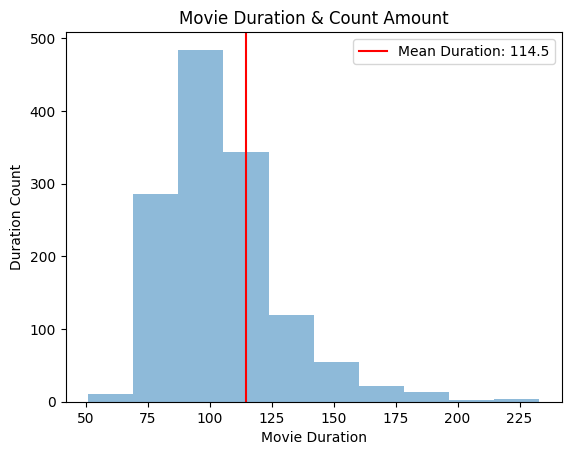

<Figure size 640x480 with 0 Axes>

In [23]:
#Exploratory Data Analysis on Duration
mean_duration = np.mean(X_train['Duration'])
mode_duration = stats.mode(X_train['Duration'])
duration_std = np.std(X_train['Duration'])
min_duration = np.min(X_train['Duration'])
print(f'Mean movie duration: {mean_duration}')
print(f'Common movie duration: {mode_duration}')
print(f'Standard Dev. Duration: {duration_std}')

#Plot movie duration
plt.hist(X_train['Duration'], align='left', alpha=0.5)
plt.title('Movie Duration & Count Amount')
plt.xlabel('Movie Duration')
plt.ylabel('Duration Count')
plt.axvline(mean_duration, color='r', label=f'Mean Duration: {np.round(mean_duration, 2)}')
plt.legend()
plt.show()
plt.clf()

Mean movie metascore: 61.44205043049473
Common movie metascore: ModeResult(mode=61.04429390307452, count=53)
Standard Dev. metascore: 17.31167875323518


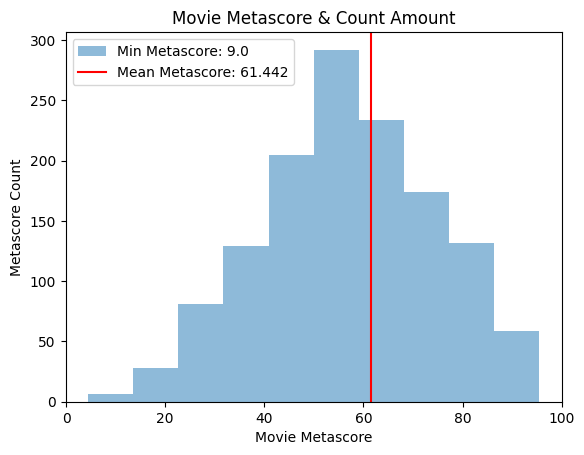

<Figure size 640x480 with 0 Axes>

In [24]:
mean_metascore = np.mean(X_train['Metascore'])
mode_metascore = stats.mode(X_train['Metascore'])
metascore_std = np.std(X_train['Metascore'])
min_metascore = np.min(X_train['Metascore'])
max_metascore = np.max(X_train['Metascore'])
print(f'Mean movie metascore: {mean_metascore}')
print(f'Common movie metascore: {mode_metascore}')
print(f'Standard Dev. metascore: {metascore_std}')

#Plot movie duration
plt.hist(X_train['Metascore'], align='left', alpha=0.5, 
         label=f'Min Metascore: {np.round(min_metascore, 3)}')
plt.title('Movie Metascore & Count Amount')
plt.xlabel('Movie Metascore')
plt.ylabel('Metascore Count')
plt.axvline(mean_metascore, color='r', label=f'Mean Metascore: {np.round(mean_metascore, 3)}')
plt.legend()
plt.show()
plt.clf()

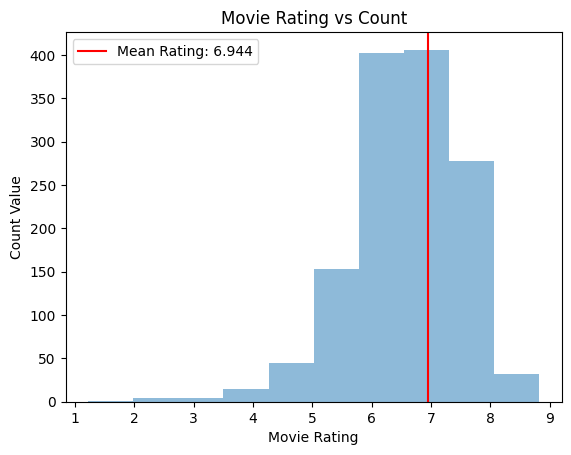

In [25]:
mean_imdb_rating = np.mean(y_train)
most_freq_imdb_rating = stats.mode(y_train)
min_rating = np.min(y_train)
max_rating = np.max(y_train)
rating_diff = max_rating - min_rating
plt.hist(y_train, align='left', alpha=0.5)
plt.title('Movie Rating vs Count')
plt.xlabel('Movie Rating')
plt.ylabel('Count Value')
plt.axvline(mean_imdb_rating, color='r', label=f'Mean Rating: {np.round(mean_imdb_rating, 3)}')
plt.legend()
plt.show()

#TO DO: Convert to a singular function

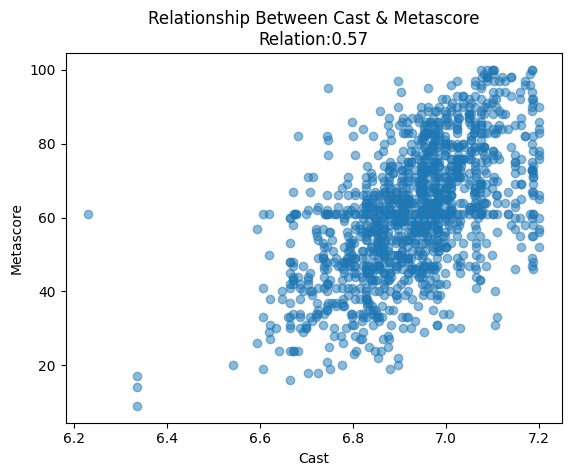

<Figure size 640x480 with 0 Axes>

In [26]:
#Relationship between cast and metascore
cast_meta_corr, _ = pearsonr(X_train['Cast'], X_train['Metascore'])
plt.scatter(X_train['Cast'], X_train['Metascore'], alpha=0.5)
plt.title(f'Relationship Between Cast & Metascore\nRelation:{np.round(cast_meta_corr, 2)}')
plt.xlabel('Cast')
plt.ylabel('Metascore')
plt.show()
plt.clf()

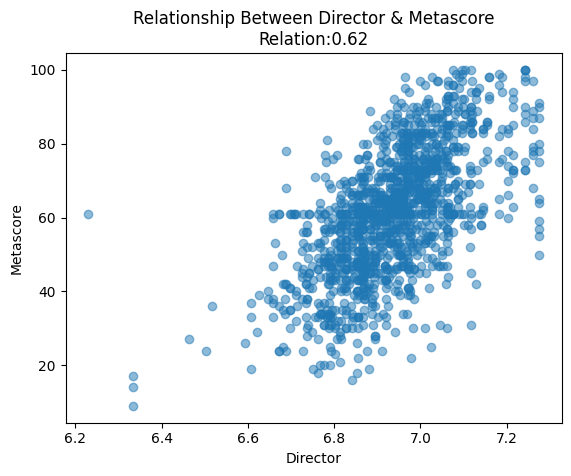

<Figure size 640x480 with 0 Axes>

In [27]:
#Relationship between director and metascore
direct_meta_corr, _ = pearsonr(X_train['Director'], X_train['Metascore'])
plt.scatter(X_train['Director'], X_train['Metascore'], alpha=0.5)
plt.title(f'Relationship Between Director & Metascore\nRelation:{np.round(direct_meta_corr, 2)}')
plt.xlabel('Director')
plt.ylabel('Metascore')
plt.show()
plt.clf()

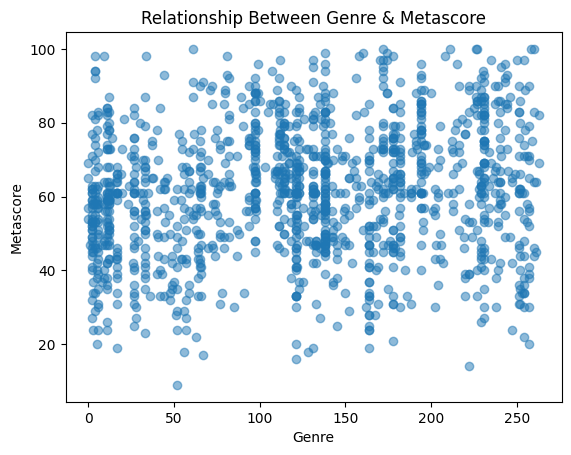

<Figure size 640x480 with 0 Axes>

In [28]:
#Relationship between cast and metascore
plt.scatter(X_train['Genre_Encoded'], X_train['Metascore'], alpha=0.5, )
plt.title('Relationship Between Genre & Metascore')
plt.xlabel('Genre')
plt.ylabel('Metascore')
plt.show()
plt.clf()

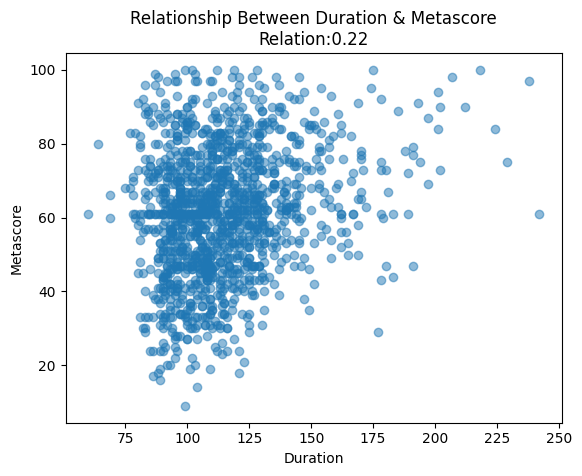

<Figure size 640x480 with 0 Axes>

In [29]:
#Relationship between cast and metascore
duration_meta_corr, _ = pearsonr(X_train['Duration'], X_train['Metascore'])
plt.scatter(X_train['Duration'], X_train['Metascore'], alpha=0.5)
plt.title(f'Relationship Between Duration & Metascore\nRelation:{np.round(duration_meta_corr,2)}')
plt.xlabel('Duration')
plt.ylabel('Metascore')
plt.show()
plt.clf()

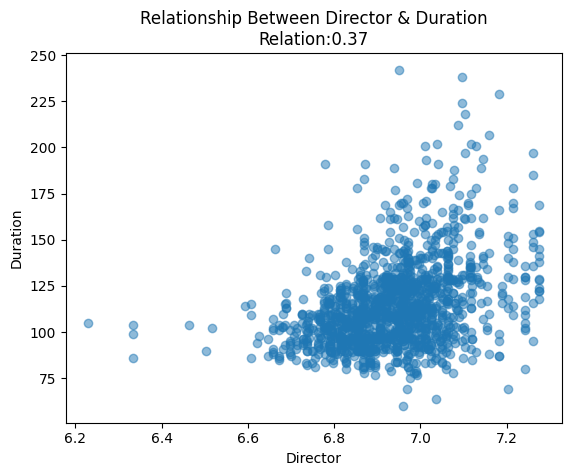

<Figure size 640x480 with 0 Axes>

In [30]:
#Relationship between Director  and Duration
duration_director_corr, _ = pearsonr(X_train['Director'], X_train['Duration'])
plt.scatter(X_train['Director'], X_train['Duration'], alpha=0.5)
plt.title(f'Relationship Between Director & Duration\nRelation:{np.round(duration_director_corr,2)}')
plt.xlabel('Director')
plt.ylabel('Duration')
plt.show()
plt.clf()

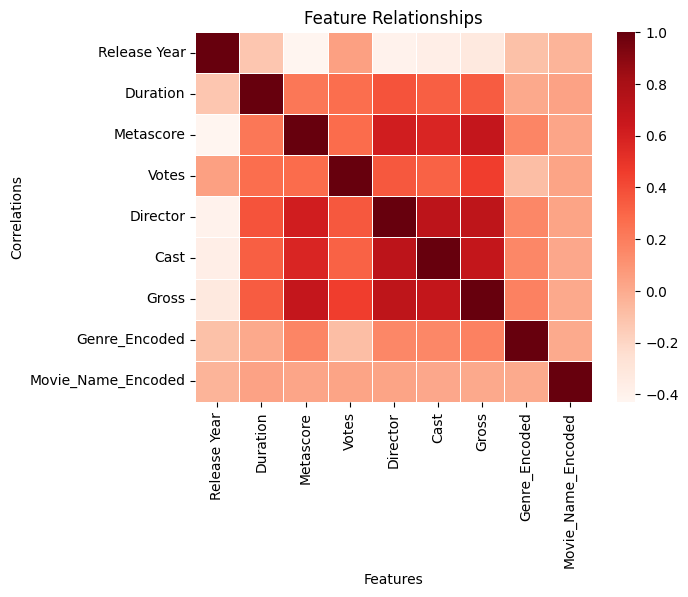

<Figure size 640x480 with 0 Axes>

In [31]:
#Full relationship display using seaborn heatmap
heatmap_corr = X_train.corr()
sns.heatmap(heatmap_corr, cmap='Reds',fmt='.1f', linewidth=0.5)
plt.title('Feature Relationships')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.show()
plt.clf()

In [190]:
#Sequential feature selection
lr = LinearRegression()
sfs = SFS(
        lr,
        k_features=5,
        forward=True,
        floating=False,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1)

In [ ]:
sfs.fit(X_train, y_train)
plot_sfs(sfs.get_metric_dict())
plt.show()

In [86]:
print(sfs.subsets_[5]['feature_names'])

('Metascore', 'Votes', 'Director', 'Cast', 'Gross')


In [87]:
print(sfs.subsets_[5]['avg_score'])

-0.09783789690355345


In [35]:
#Creating a new X_train set
selected_features = [feature for feature in sfs.subsets_[5]['feature_names']]
X_train_chosen = X_train[selected_features]
X_test_chosen = X_test[selected_features]

In [36]:
#standardizing the votes, metascore and duratio
scaler = StandardScaler()

X_train_selected = scaler.fit_transform(X_train_chosen)
X_test_selected = scaler.transform(X_test_chosen)

In [40]:
lr = LinearRegression()
lr.fit(X_train_selected, y_train)

LinearRegression()

In [48]:
#Linear regression score
lr_score_train = lr.score(X_train_selected, y_train)
lr_score_test = lr.score(X_test_selected, y_test)

In [52]:
print(f'Linear Regression Score (training set): {np.round(lr_score_train, 2)}')
print(f'Linear Regression Score (test set): {np.round(lr_score_test, 2)}')

Linear Regression Score (training set): 0.89
Linear Regression Score (test set): 0.86


In [54]:
#GridSearchCV
print(lr.get_params())
params = {'fit_intercept':[True, False], 'positive':[True, False]}
gs = GridSearchCV(lr, params)
gs.fit(X_train_selected, y_train)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]})

In [58]:
best_model = gs.best_estimator_
best_params = gs.best_params_
best_score = gs.best_score_
print(best_model)
print(best_params)
print(best_score)

LinearRegression(positive=True)
{'fit_intercept': True, 'positive': True}
0.8881274130922217


In [61]:
gs.fit(X_test_selected, y_test)
best_test_score = gs.best_score_
best_test_params = gs.best_params_ 
print(best_test_score)
print(best_test_params)

0.863639723628447
{'fit_intercept': True, 'positive': True}


In [63]:
lr_best = LinearRegression(fit_intercept=True, positive=True)
lr_best.fit(X_train_selected, y_train)

LinearRegression(positive=True)

In [65]:
new_test_score = lr_best.score(X_test_selected, y_test)
new_train_score = lr_best.score(X_train_selected, y_train)
print(new_test_score)
print(new_train_score)

0.8648069674680857
0.8914329807366913


In [130]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class NumericCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        X = X.apply(lambda x: x.str.replace(',', '')).astype('int')
        
        return X

In [212]:
class YearCleanser(BaseEstimator, TransformerMixin):
    def __init__(self, params=None):
        self.params = params
        
    def fit(self, X, y=None):
        return self


    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = X.replace(self.params, regex=True)
        X = X.astype('int')
        return X
        

In [195]:
replacements = {
    'II': '',
    'I': '',
    'Video': '',
    '1995[–-]2016': '1995', 
    '1964[–-]1968': '1964', 
    'TV Movie': ''
}

In [245]:
#Building a pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols_ohe = X_train[['Genre']].columns
cat_cols = X_train.select_dtypes(include=['object']).drop(columns=['Votes', 'Genre', 'Release Year']).columns
year_col = X_train[['Release Year']].columns


num_pipe = Pipeline([("imputer", SimpleImputer(strategy='mean')),
                     ("scaler", StandardScaler())])

cat_ohe_pipe = Pipeline([
                     ("imputer", SimpleImputer(strategy='most_frequent')),
                     ("label", OneHotEncoder(drop='first', handle_unknown='ignore'))])

cat_target_pipe = Pipeline([
                       ("imputer", SimpleImputer(strategy='most_frequent')),
                       ("target", TargetEncoder()),
                       ("scaler", StandardScaler())])

pipeline_votes = Pipeline([
                 ("impute", SimpleImputer(strategy='most_frequent')),
                 ("cleaner", NumericCleaner()),
                 ("scaler", StandardScaler())])

year_cleaner = Pipeline([
                       ("imputer", SimpleImputer(strategy='most_frequent')),
                       ("year_converter", YearCleanser(params=replacements)),
                       ("scaler", StandardScaler())])

preprocessing = ColumnTransformer(
                transformers=[
                              ("num_cleaner", num_pipe, num_cols),
                              ("cleaner", pipeline_votes, ['Votes']),
                              ("cat_ohe_cleaner", cat_ohe_pipe, cat_cols_ohe),
                              ("cat_tar_cleaner", cat_target_pipe, cat_cols),
                              ("year_cleanser", year_cleaner, year_col)])

pipeline = Pipeline([("preprocess", preprocessing),
                     ("sfs", sfs),
                     ("regr", SVR(kernel='linear'))])

pipeline.fit(X_train, y_train)
# changed = year_cleaner.transform(X_test[['Release Year']])
# print(changed)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_cleaner',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Duration', 'Metascore'], dtype='object')),
                                                 ('cleaner',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cleaner',
                                                                   NumericCleaner()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Votes']),
                                                 ('c...
                                                                  ('year_converter',
                                                                   YearCleanser(params={'1964[–-]1968': '1964',
                                                                                        '1995[–-]2016': '1995',
                                                                                        'I': '',
                                                                                        'II': '',
                                                                                        'TV Movie': '',
                                                                                        'Video': ''})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Release Year'], dtype='object'))])),
                ('sfs',
                 SequentialFeatureSelector(cv=3, estimator=LinearRegression(),
                                           k_features=(5, 5), n_jobs=-1,
                                           scoring='neg_mean_squared_error')),
                ('regr', SVR(kernel='linear'))])

In [246]:
score_test = pipeline.score(X_test, y_test)
score_train = pipeline.score(X_train, y_train)
print(score_test)
print(score_train)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.5625438998917127
0.6717282932844271


In [ ]:
#GridSearch 
param_grid = {'regr__gamma':['scale', 'auto'], 'regr__degree':[3, 5, 6, 7,8, 9,12], 'regr__C': [1.0, 3.0, 2.0, 5.0]}
gs = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
gs.fit(X_train, y_train)
best_score = gs.best_score_
best_params = gs.best_params_
print(best_score)
print(best_params)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all